In [ ]:
!cp -r /content/drive/MyDrive/single .

In [1]:
!cp -r /content/drive/MyDrive/datset .

In [2]:
import tensorflow as tf
import os
import numpy as np
import random
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage import color
import matplotlib.pyplot as plt
import glob
from tensorflow.keras.utils import to_categorical
from sklearn.utils import class_weight

number_of_classes = 6

def load_data(img_width = 256, img_height = 256, path = 'single/train/', test = False):

    # Function that loads multiclass data from my folder and returns X_train and Y_train arrays

    file_names = glob.glob(path + 'images/*')
    X_train = np.zeros((len(file_names), img_width, img_height), dtype = np.float)
    temp_array = np.zeros((len(file_names),number_of_classes-1 , img_width, img_height), dtype = np.int) # an array used for some dirty sorcery
    Y_train = np.zeros((len(file_names), img_width, img_height), dtype = np.int)
    n = 0
    
    for file in glob.glob(path + 'images/*'):
        # Load image
        img = color.rgb2gray(imread(file)) # convert to grayscale
        img = resize(img, (img_height, img_width), mode='constant', preserve_range=True)
        X_train[n] = img

        # Load masks
        if not test:
          rtop = imread(file[0:13]+ 'masks/'+ file[20:30]+ '_Rhigh.ome.tiff', as_gray=True)
          rtop = resize(rtop, (img_height, img_width), mode='constant', preserve_range=True)
          temp_array[n][0] = rtop # temp_array is used to contain images and automaticaly convert to integer
          # value for first class is already "1"

          rmid = imread(file[0:13]+ 'masks/'+ file[20:30]+ '_Rmid.ome.tiff', as_gray=True)
          rmid = resize(rmid, (img_height, img_width), mode='constant', preserve_range=True)
          temp_array[n][1] = rmid
          temp_array[n][1][temp_array[n][1] == 1] = 2 # changing every "1" with "2" so pixels for second class are "2"
          Y_train[n] = np.bitwise_or(temp_array[n][0],temp_array[n][1]) # adding two masks together

          rbot = imread(file[0:13]+ 'masks/'+ file[20:30]+ '_Rlow.ome.tiff', as_gray=True)
          rbot = resize(rbot, (img_height, img_width), mode='constant', preserve_range=True)
          temp_array[n][2] = rbot
          temp_array[n][2][temp_array[n][2] == 1] = 3
          Y_train[n] = np.bitwise_or(Y_train[n],temp_array[n][2]) # adding previous mask with new one

          ltop = imread(file[0:13]+ 'masks/'+ file[20:30]+ '_Lhigh.ome.tiff', as_gray=True)
          ltop = resize(ltop, (img_height, img_width), mode='constant', preserve_range=True)
          temp_array[n][3] = ltop
          temp_array[n][3][temp_array[n][3] == 1] = 4
          Y_train[n] = np.bitwise_or(Y_train[n],temp_array[n][3])

          lbot = imread(file[0:13]+ 'masks/'+ file[20:30]+ '_Llow.ome.tiff', as_gray=True)
          lbot = resize(lbot, (img_height, img_width), mode='constant', preserve_range=True)
          temp_array[n][4] = lbot
          temp_array[n][4][temp_array[n][4] == 1] = 5

          Y_train[n] = np.bitwise_or(Y_train[n],temp_array[n][4]) # finally sum it all up
        n+=1

    if not test:
      return X_train, Y_train

    return X_train

X_train, Y_train = load_data(img_width = 256, img_height = 256, path = 'datset/train/')
X_test = load_data(path = 'datset/test/', test = True)


Dataset contains  69  images


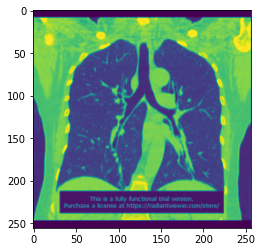

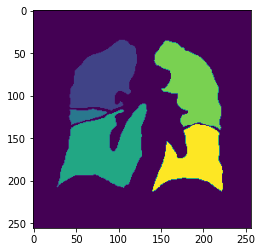

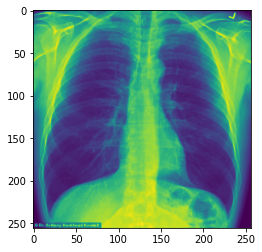

In [3]:
print('Dataset contains ', len(X_train), ' images')
plt.imshow(X_train[len(X_train)-10])
plt.show()
plt.imshow(Y_train[len(X_train)-10])
plt.show()

plt.imshow(X_test[1])
plt.show()

In [4]:
X_train = np.expand_dims(X_train, axis=3)
Y_train = np.expand_dims(Y_train, axis=3)
Y_train_categorical = to_categorical(Y_train, num_classes=number_of_classes)
#Y_train_categorical = Y_train_categorical.reshape((Y_train.shape[0], Y_train.shape[1], Y_train.shape[2], number_of_classes))


In [ ]:
print(np.shape(X_train))

print(np.shape(Y_train))
print(np.shape(Y_train_categorical))

(54, 256, 256, 1)
(54, 256, 256, 1)
(54, 256, 256, 6)


In [ ]:
# class weigths

In [5]:
def set_model(filters = 16, dropout = 0.01, img_width = 256, img_height = 256, number_of_classes = 6):
  inputs = tf.keras.layers.Input((img_width, img_height, 1))
  s = tf.keras.layers.Lambda(lambda x: x / 255)(inputs)
 
  c1 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
  c1 = tf.keras.layers.Dropout(dropout)(c1)
  c1 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
  p1 = tf.keras.layers.MaxPooling2D((2, 2))(c1)
 
  c2 = tf.keras.layers.Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
  c2 = tf.keras.layers.Dropout(dropout)(c2)
  c2 = tf.keras.layers.Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
  p2 = tf.keras.layers.MaxPooling2D((2, 2))(c2)
 
  c3 = tf.keras.layers.Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
  c3 = tf.keras.layers.Dropout(dropout + 0.1)(c3)
  c3 = tf.keras.layers.Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
  p3 = tf.keras.layers.MaxPooling2D((2, 2))(c3)
 
  c4 = tf.keras.layers.Conv2D(filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
  c4 = tf.keras.layers.Dropout(dropout + 0.1)(c4)
  c4 = tf.keras.layers.Conv2D(filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
  p4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(c4)
 
  c5 = tf.keras.layers.Conv2D(filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
  c5 = tf.keras.layers.Dropout(dropout + 0.2)(c5)
  c5 = tf.keras.layers.Conv2D(filters*16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
 
  ################### expansive path 

  u6 = tf.keras.layers.Conv2DTranspose(filters*8, (2, 2), strides=(2, 2), padding='same')(c5)
  u6 = tf.keras.layers.concatenate([u6, c4])
  c6 = tf.keras.layers.Conv2D(filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
  c6 = tf.keras.layers.Dropout(dropout + 0.1)(c6)
  c6 = tf.keras.layers.Conv2D(filters*8, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
 
  u7 = tf.keras.layers.Conv2DTranspose(filters*4, (2, 2), strides=(2, 2), padding='same')(c6)
  u7 = tf.keras.layers.concatenate([u7, c3])
  c7 = tf.keras.layers.Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
  c7 = tf.keras.layers.Dropout(dropout + 0.1)(c7)
  c7 = tf.keras.layers.Conv2D(filters*4, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
 
  u8 = tf.keras.layers.Conv2DTranspose(filters*2, (2, 2), strides=(2, 2), padding='same')(c7)
  u8 = tf.keras.layers.concatenate([u8, c2])
  c8 = tf.keras.layers.Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
  c8 = tf.keras.layers.Dropout(dropout)(c8)
  c8 = tf.keras.layers.Conv2D(filters*2, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
 
  u9 = tf.keras.layers.Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(c8)
  u9 = tf.keras.layers.concatenate([u9, c1], axis=3)
  c9 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
  c9 = tf.keras.layers.Dropout(dropout)(c9)
  c9 = tf.keras.layers.Conv2D(filters, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
 
  outputs = tf.keras.layers.Conv2D(number_of_classes, (1, 1), activation='softmax')(c9)
 
  model = tf.keras.Model(inputs = [inputs], outputs = [outputs])
  return model

model = set_model(img_width = 256, img_height = 256, filters = 12, dropout = 0.1, number_of_classes = number_of_classes)

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy']) # i can use focal loss
#model.summary()

#Callbacks
checkpointer = tf.keras.callbacks.ModelCheckpoint('best.h5', verbose = 1, save_best_only = True)
callbacks = [tf.keras.callbacks.TensorBoard(log_dir='logs'), #make logs
             checkpointer] #save checkpoints

################### train model

results = model.fit(X_train,
                    Y_train_categorical,
                    validation_split = 0.2,
                    batch_size = 12,
                    epochs=200,
                    callbacks=callbacks)

#model = tf.keras.models.load_model("best.h5")


Epoch 1/200
5/5 [==============================] - 38s 1s/step - loss: 1.7843 - accuracy: 0.6209 - val_loss: 1.7664 - val_accuracy: 0.7802

Epoch 00001: val_loss improved from inf to 1.76637, saving model to best.h5
Epoch 2/200
5/5 [==============================] - 1s 228ms/step - loss: 1.7414 - accuracy: 0.7254 - val_loss: 1.6261 - val_accuracy: 0.4419

Epoch 00002: val_loss improved from 1.76637 to 1.62605, saving model to best.h5
Epoch 3/200
5/5 [==============================] - 1s 236ms/step - loss: 1.4334 - accuracy: 0.4870 - val_loss: 1.4723 - val_accuracy: 0.7802

Epoch 00003: val_loss improved from 1.62605 to 1.47233, saving model to best.h5
Epoch 4/200
5/5 [==============================] - 1s 226ms/step - loss: 1.2460 - accuracy: 0.7503 - val_loss: 1.0863 - val_accuracy: 0.7802

Epoch 00004: val_loss improved from 1.47233 to 1.08626, saving model to best.h5
Epoch 5/200
5/5 [==============================] - 1s 237ms/step - loss: 1.0831 - accuracy: 0.7838 - val_loss: 1.0529 

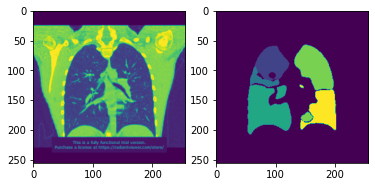

In [10]:
y_pred=model.predict(X_test)
y_pred_argmax=np.argmax(y_pred, axis=3)

ix = 3
f, axarr = plt.subplots(1,2) 
#axarr[0].imshow(np.squeeze(X_test[ix], axis = 1))
axarr[0].imshow(X_test[ix])
axarr[1].imshow(y_pred_argmax[ix])
plt.show()

In [ ]:
np.shape(X_test)

(0, 256, 256)